Evaluate SB limit after N years

Still to do:
* use seeing in db rather than assuming fixed seeing
* Add and recover fake galaxies

In [1]:
from __future__ import print_function
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles
import math

In [2]:
# This is needed to avoid an error when a metric is redefined
from lsst.sims.maf.metrics import BaseMetric
try:
    del metrics.BaseMetric.registry['__main__.SB']
except KeyError:
    pass

In [3]:
class SB(BaseMetric):
    """Calculate the SB at this gridpoint."""
    def __init__(self, m5Col = 'fiveSigmaDepth', metricName='SB', **kwargs):
        """Instantiate metric.

        m5col = the column name of the individual visit m5 data."""
        super(SB, self).__init__(col=m5Col, metricName=metricName, **kwargs)
    def run(self, dataSlice, slicePoint=None):
        seeing = 0.7
        return 1.25 * np.log10(np.sum(10.**(.8*dataSlice[self.colname])) * (math.pi*seeing**2))

In [4]:
filterName = 'r'
years = [1, 2, 3, 5, 10]
colors = ['y', 'g', 'r', 'b', 'k']
nights = np.array(years)*365.25
sqls = ['filter = "%s" and night < %f' %(filterName, night) for night in nights]
print(sqls)

['filter = "r" and night < 365.250000', 'filter = "r" and night < 730.500000', 'filter = "r" and night < 1095.750000', 'filter = "r" and night < 1826.250000', 'filter = "r" and night < 3652.500000']


In [5]:
# Set up the database connection
dbdir = '../../tutorials'
opsdb = db.OpsimDatabase(database = os.path.join(dbdir, 'astro-lsst-01_2022.db'))
runName = 'astro-lsst-01_2022'
outDir = 'GoodSeeing'
resultsDb = db.ResultsDb(outDir=outDir)

In [6]:
slicer = slicers.HealpixSlicer(latLonDeg=True)
summaryMetrics = [metrics.MeanMetric(), metrics.MedianMetric()]
metric = SB()
bundles = {}
for year, sql in zip(years,sqls):
    bundle = metricBundles.MetricBundle(metric, slicer, sql, summaryMetrics=summaryMetrics)
    plotDict = {'label': '%i' % year, 'title': '%s %s band year %d' % (runName, filterName, year)}
    bundle.setPlotDict(plotDict)
    bundles[year] = bundle

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


In [7]:
bgroup = metricBundles.MetricBundleGroup(bundles, opsdb, outDir, resultsDb)
bgroup.runAll()

Querying database SummaryAllProps with constraint filter = "r" and night < 365.250000 for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 39324 visits
Running:  [1]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "r" and night < 730.500000 for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 83867 visits
Running:  [2]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "r" and night < 3652.500000 for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 515172 visits
Running:  [10]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "r" and night < 1095.750000 for columns ['fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 145463 visits
Running:  [3]
Completed metric generation

monopole: 25.6908  dipole: lon: -177.111, lat: -42.8166, amp: 0.416332
monopole: 26.0791  dipole: lon: -166.921, lat: -58.549, amp: 0.229935
monopole: 26.4022  dipole: lon: 155.005, lat: -70.4335, amp: 0.229762
monopole: 26.6875  dipole: lon: 163.143, lat: -69.5369, amp: 0.194631
monopole: 27.0679  dipole: lon: 144.232, lat: -75.9661, amp: 0.186129


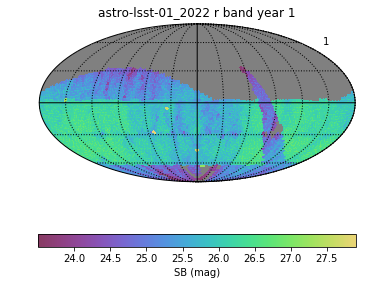

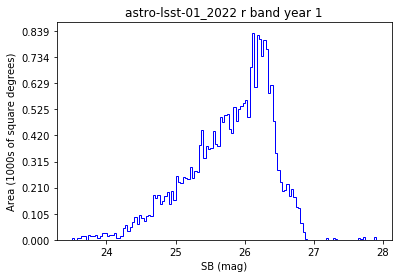

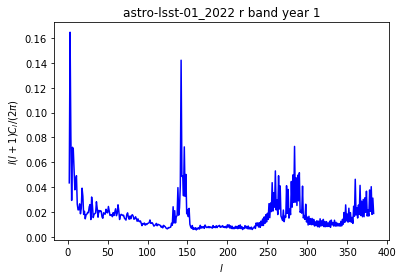

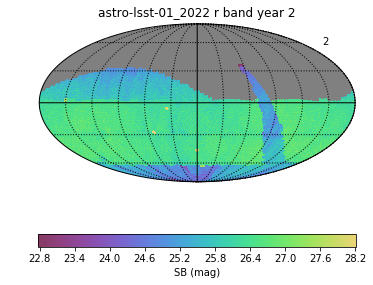

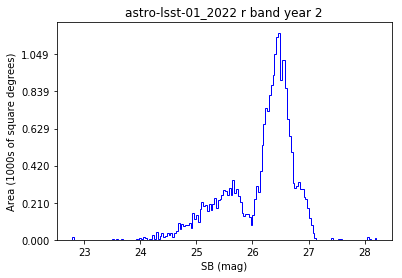

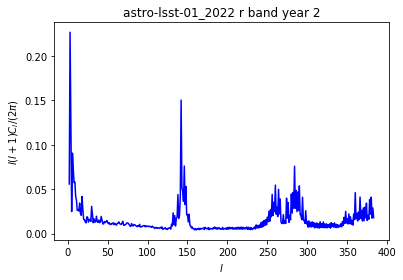

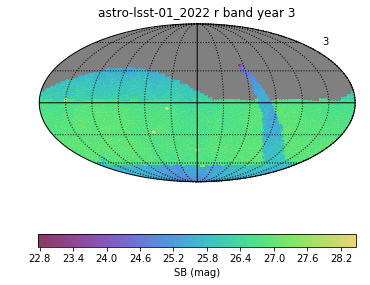

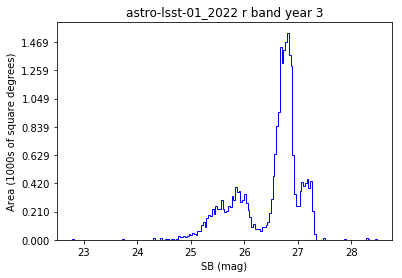

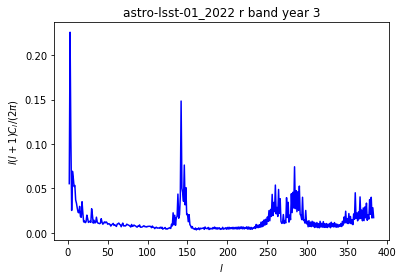

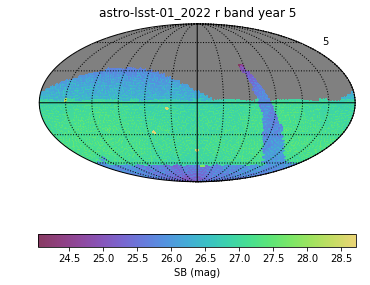

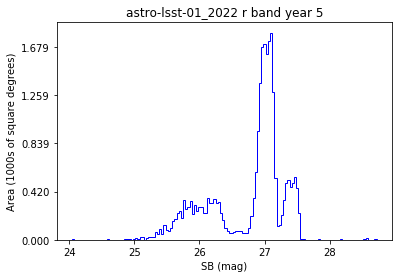

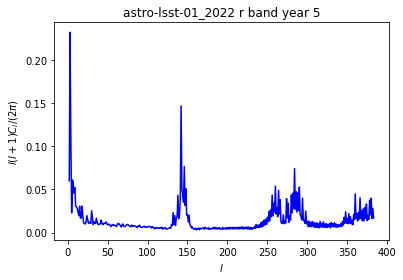

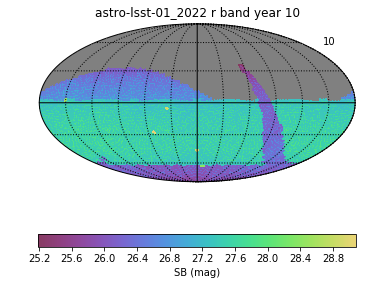

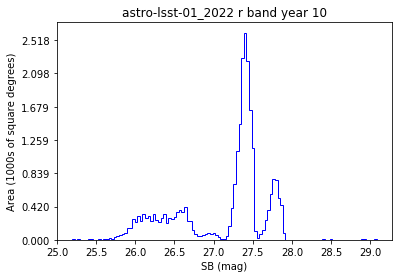

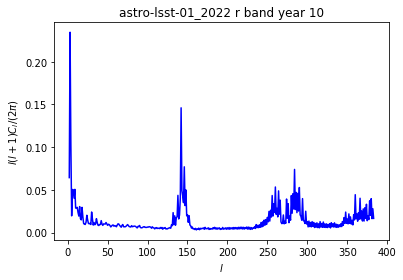

In [8]:
for year in years:
    bundles[year].plot()

In [9]:
mean_depth = []
median_depth = []
print('Yr Mean_depth  Median_depth')
for i, year in enumerate(years):
    mean_depth.append(bundles[year].summaryValues['Mean'])
    median_depth.append(bundles[year].summaryValues['Median'])
    plotDict = {'label': 'Yr %d Mean %.2f Median %.2f' % (year, mean_depth[i], median_depth[i]),
               'color': colors[i]}
    bundles[year].setPlotDict(plotDict)
    print(year, mean_depth[i], median_depth[i])

Yr Mean_depth  Median_depth
1 25.7860862021 25.9034496586
2 26.1446987977 26.3424741125
3 26.4806692218 26.6956721097
5 26.7528606745 26.9754926609
10 27.133438091 27.3704952655


/Users/lynnej/lsstsw2/miniconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


1

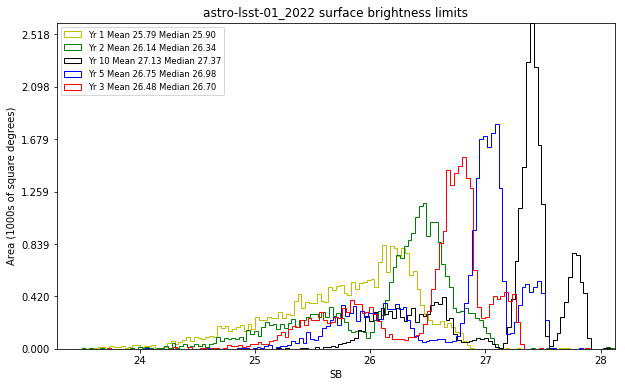

In [10]:
ph = plots.PlotHandler()
ph.setMetricBundles(bundles)
ph.plot(plotFunc=plots.HealpixHistogram(), plotDicts={'title': '%s surface brightness limits' % (runName), 'figsize': (10, 6), 'legendloc': 'upper left'})

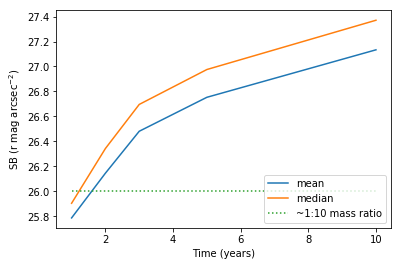

In [11]:
# Plot SB limits as fn of time
plt.clf()
plt.plot(years, mean_depth, label='mean')
plt.plot(years, median_depth, label='median')
plt.plot((years[0], years[-1]), (26, 26), ':', label='~1:10 mass ratio')
plt.xlabel('Time (years)')
plt.ylabel(r'SB (r mag arcsec$^{-2}$)')
plt.legend(loc=4)
plt.show()